# Auto-iterative self-training system for small crater detection

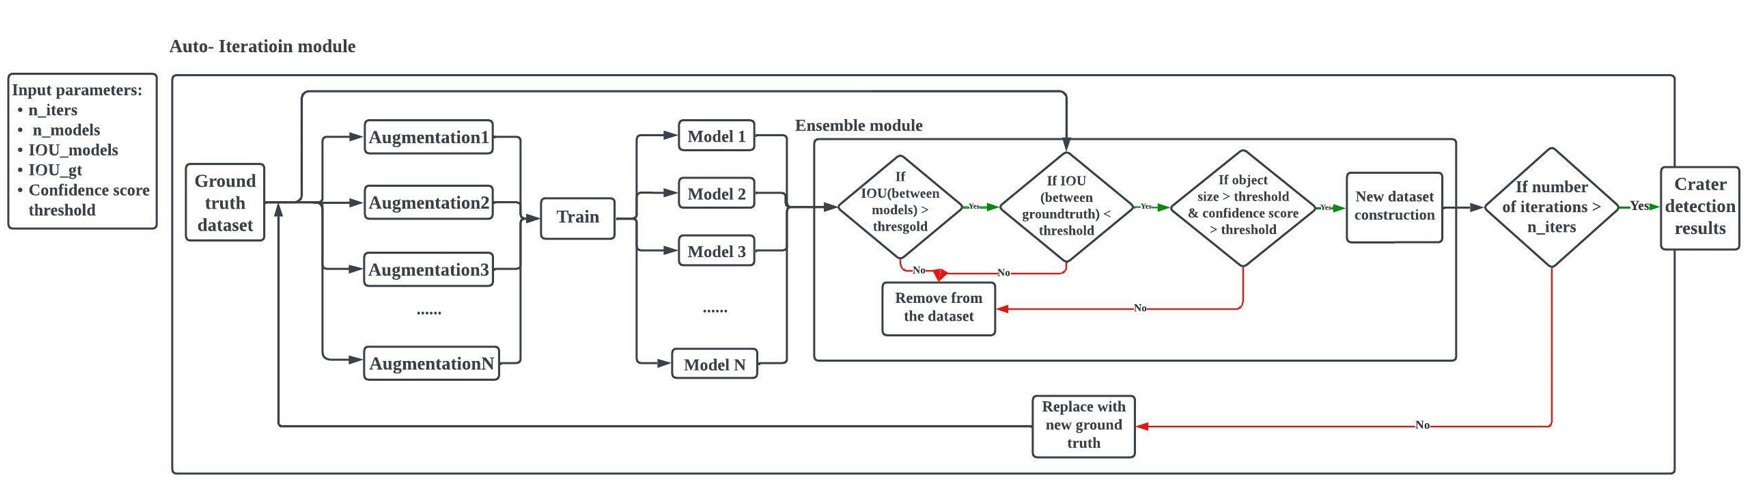

## Step1. Install requirements

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install ultralytics==8.0.100
!pip install Pillow==9.5.0
import pylab as plt
from pylab import *
import numpy as np
import pandas as pd
import os
import torch
import time

import yaml
import os
import random
from os import listdir
from PIL import Image as PImage
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import cv2
%matplotlib inline

from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.1/585.1 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 76.4 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: pillow 10.4.0
    Uninstalling pillow-10.4.0:
      Successfully uninstalled pillow-10.4.0


Setup complete. Using torch 2.4.1+cu121 (NVIDIA A100-SXM4-40GB)


## Download the training dataset for self-training (from robotflow)

In [ ]:
!pip install roboflow
%cd /content/drive/MyDrive/yolov5/data
from roboflow import Roboflow
rf = Roboflow(api_key="Sf4KX5xghK43qDvdyOmX")
project = rf.workspace("imperial-college-london-52ovf").project("themis_data-j6jnk")
version = project.version(10)
dataset = version.download("yolov5")


/content/drive/MyDrive/yolov5/data
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to THEMIS_DATA-10 in yolov5pytorch:: 100%|██████████| 2068/2068 [00:11<00:00, 172.79it/s]


## Step3. Upload the required files (ensemble module and data.yaml)

Download the files required using this link: https://drive.google.com/drive/folders/1bVjNFMKAGR0kRAFr85jKnO4M8yEUtlpw?usp=sharing
Upload this file into colab

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving upload_files-20220901T093233Z-001.zip to upload_files-20220901T093233Z-001.zip


In [ ]:
name = str(uploaded.keys()).split('\'')[1https://www.google.com/url?q=https%3A%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F177_dOTySsoOBehovgjRHAoJrnJFAVU40%3Fusp%3Dsharing]
!unzip {name}

Archive:  upload_files-20220901T093233Z-001.zip
replace upload_files/crater.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: upload_files/crater.yaml  
  inflating: upload_files/Label_rescale.py  
  inflating: upload_files/rename.py  
  inflating: upload_files/ensemble.py  


## Run the Self-training system

In [ ]:
%cd /content/drive/MyDrive/yolov5

import os
import yaml
import shutil
import random
from datetime import datetime

# Function to set hyperparameters and ground truth paths
def set_hyp(state):
    file_name = "/content/drive/MyDrive/yolov5/data/hyps/hyp.scratch-low.yaml"
    with open(file_name) as f:
        doc = yaml.safe_load(f)

    doc['hsv_s'] = (1 - state) / 1.5
    doc['hsv_v'] = state
    doc['scale'] = state
    doc['shear'] = state / 2

    with open(file_name, 'w') as f:
        yaml.safe_dump(doc, f, default_flow_style=False)
    print('Hyperparameters updated:', doc)

def set_gt(pathgt):
    file_name = "/content/drive/MyDrive/yolov5/data/crater.yaml"
    with open(file_name) as f:
        doc = yaml.safe_load(f)

    doc['train'] = pathgt

    with open(file_name, 'w') as f:
        yaml.safe_dump(doc, f, default_flow_style=None)

    print('Ground truth updated:', doc)

# Setting input parameters
n_models = 2
n_iterations = 10

# Set up paths and clear or create directories
script_path = os.path.realpath('/content/drive/MyDrive/yolov5')
new_abs_path = os.path.join(script_path, 'ensemble_results')
if os.path.exists(new_abs_path):
    shutil.rmtree(new_abs_path)
os.mkdir(new_abs_path)

# Main loop for iterations
counter_ensemble = 1
run_name_dict = []  # To keep track of run names for loading weights

# check the raw label files
base_path = "/content/drive/MyDrive/yolov5/THEMIS_DATA-10/"
if os.path.isdir(base_path + "train/labels_backup"):
  !rm -r "{base_path}train/labels"
  !cp -r "{base_path}train/labels_backup" "{base_path}train/labels"
else:
  raise Exception("No backup labels. Stop.")



for j in range(n_iterations):
    pathtxt = []

    # Set paths for training data based on iteration
    if j == 0:
        pathgt_train = '/content/drive/MyDrive/yolov5/THEMIS_DATA-10/train/images'
        pathgt = '/content/drive/MyDrive/yolov5/THEMIS_DATA-10/train/labels'
        initial_weights = 'yolov5s.pt'  # Initial weights for the first iteration
    else:
        pathgt_train = f'/content/drive/MyDrive/yolov5/ensemble_results3/loop{counter_ensemble-1}/images'
        pathgt = f'/content/drive/MyDrive/yolov5/ensemble_results3/loop{counter_ensemble-1}/labels'
        initial_weights = f'runs/train/{run_name_dict[2*j-2]}/weights/best.pt'  # Weights from the previous iteration

        # Replace the current labels to the previous generated
        !rm -r "{base_path}train/labels"
        !cp -r "{pathgt}" "{base_path}train/labels"

    # Training loop for each model
    for i in range(n_models):
        state = random.uniform(0, 0.5)
        set_gt(pathgt_train)
        set_hyp(state)

        with open('/content/drive/MyDrive/yolov5/data/crater.yaml', 'r') as f:
            data = yaml.safe_load(f)
        print(data)

        # Generate a unique name for the training run using a timestamp
        run_name = datetime.now().strftime("%Y%m%d_%H%M%S")

        print('initial weights:',initial_weights)
        # Run training with the appropriate weights
        # !python train.py --img 416 --batch 16 --epochs 15 --data /content/drive/MyDrive/yolov5/data/crater.yaml --weights {initial_weights} --hyp data/hyps/hyp.scratch-low.yaml --cache --project runs/train --name {run_name}

        !python train.py --img 416 --batch 16 --epochs 60 --data /content/drive/MyDrive/yolov5/data/crater.yaml --weights {initial_weights} --hyp data/hyps/hyp.scratch-low.yaml --cache --project runs/train --name {run_name}

        # Use the same `run_name` for detection to ensure matching names
        detect_command = f'python detect.py --weights runs/train/{run_name}/weights/best.pt --img 416 --conf 0.1 --source /content/drive/MyDrive/yolov5/THEMIS_DATA-10/train/images --save-txt --save-conf --project runs/detect --name {run_name}'
        with open('detect.sh', 'w') as f:
            f.write(detect_command)
        !sh detect.sh

        # Append the detection path for ensemble processing
        pathtxt.append(f'./runs/detect/{run_name}/labels/crater')
        run_name_dict.append(run_name)  # Save the current run name for the next iteration

    # Create loop directories for ensemble results
    loop_path = os.path.join(new_abs_path, f'loop{counter_ensemble}')
    os.mkdir(loop_path)
    label_path = os.path.join(loop_path, 'labels')
    if not os.path.exists(label_path):
        os.mkdir(label_path)
        with open('ln.sh', 'w') as f:
            f.write(f'ln -s /content/drive/MyDrive/yolov5/THEMIS_DATA-10/train/images /content/drive/MyDrive/yolov5/ensemble_results/loop{counter_ensemble}')
        !sh ln.sh

    # Run the ensemble script with updated paths
    pathsave = label_path
    pathimg = '/content/drive/MyDrive/yolov5/THEMIS_DATA-10/train/images'
    !python /content/drive/MyDrive/yolov5/ensemble.py --gt {pathgt} --nargs {pathtxt} --pathimg {pathimg} --n_models {n_models} --pathsave {pathsave} --loop {counter_ensemble}

    counter_ensemble += 1
    print(f'Start {counter_ensemble} iteration')


Streaming output truncated to the last 5000 lines.
after gt 19
after conf score 19
before save 19
save /content/drive/MyDrive/yolov5/ensemble_results/loop10/labels/crater
Pocessing file 298
/content/drive/MyDrive/yolov5/ensemble_results3/loop9/labels/crater299.txt
/content/drive/MyDrive/yolov5/ensemble_results3/loop9/labels/crater299.txt
before ensemble 3
after ensemble 31
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
after gt 31
after conf score 31
before save 31
save /content/drive/MyDrive/yolov5/ensemble_results/loop10/labels/crater
Pocessing file 299
/content/drive/MyDrive/yolov5/ensemble_results3/loop9/labels/crater300.txt
/content/drive/MyDrive/yolov5/ensemble_results3/loop9/labels/crater300.txt
before ensemble 3
after ensemble 12
[1. 1. 1. 1. 1. 1. 1. 1.]
after gt 12
after conf score 12
before save 12
save /content/drive/MyDrive/yolov5/ensemble_results/loop10/labels/crater
Pocessing file 300
/content/drive/MyDrive/yolov5/ensemble_results3/loop9/labels/crater301.txt
/co